## Load Libraries

In [1]:
import os
import random
import numpy as np
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

## Configuration

In [2]:

original_dataset_dir = "../data/Guava_Leaf"
output_dir = "../augmented_data"
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15

BALANCE_DATASET = True
TARGET_SAMPLES_PER_CLASS = (None)

## Advanced Augmentation Functions

### Cut MIx

In [3]:
def cutmix_augmentation(img1, img2, alpha=1.0, image_size=(224, 224)):
    transform = transforms.Compose(
        [transforms.Resize(image_size), transforms.ToTensor()]
    )

    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    img1_tensor = transform(img1)
    img2_tensor = transform(img2)

    channels, height, width = img1_tensor.shape

    cut_rat = np.sqrt(1.0 - lam)
    cut_w = int(width * cut_rat)
    cut_h = int(height * cut_rat)

    cx = np.random.randint(width)
    cy = np.random.randint(height)

    bbx1 = np.clip(cx - cut_w // 2, 0, width)
    bby1 = np.clip(cy - cut_h // 2, 0, height)
    bbx2 = np.clip(cx + cut_w // 2, 0, width)
    bby2 = np.clip(cy + cut_h // 2, 0, height)

    img1_tensor[:, bby1:bby2, bbx1:bbx2] = img2_tensor[:, bby1:bby2, bbx1:bbx2]

    return transforms.ToPILImage()(img1_tensor)

### Mix up

In [4]:
def mixup_augmentation(img1, img2, alpha=0.2, image_size=(224, 224)):
    transform = transforms.Compose(
        [transforms.Resize(image_size), transforms.ToTensor()]
    )

    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    img1_tensor = transform(img1)
    img2_tensor = transform(img2)
    
    mixed_img = lam * img1_tensor + (1 - lam) * img2_tensor

    return transforms.ToPILImage()(mixed_img)

### Mosaic

In [5]:
def mosaic_augmentation(images, image_size=(224, 224)):
    if len(images) < 4:
        while len(images) < 4:
            images.extend(images[: 4 - len(images)])

    quarter_size = (image_size[0] // 2, image_size[1] // 2)
    resized_imgs = [img.resize(quarter_size) for img in images[:4]]

    mosaic_img = Image.new("RGB", image_size)
    mosaic_img.paste(resized_imgs[0], (0, 0))
    mosaic_img.paste(resized_imgs[1], (quarter_size[0], 0))
    mosaic_img.paste(resized_imgs[2], (0, quarter_size[1]))
    mosaic_img.paste(resized_imgs[3], (quarter_size[0], quarter_size[1]))

    return mosaic_img

## Visualize Class Distribution

In [6]:
def get_class_distribution(data_dir):
    class_counts = {}
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            images = [
                f
                for f in os.listdir(class_path)
                if f.lower().endswith(("png", "jpg", "jpeg"))
            ]
            class_counts[class_name] = len(images)
    return class_counts

In [7]:
def visualize_distribution(data_dir, title="Class Distribution"):
    class_counts = get_class_distribution(data_dir)
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.figure(figsize=(10, 6))
    sns.barplot(x=classes, y=counts)
    plt.xticks(rotation=45)
    plt.title(title)
    plt.ylabel("Number of Samples")
    plt.xlabel("Class")
    plt.tight_layout()
    plt.show()

    return class_counts

## Create Output Directories

In [8]:
for split in ["train", "val", "test"]:
    split_dir = os.path.join(output_dir, split)
    os.makedirs(split_dir, exist_ok=True)

print("Output directories created!")

Output directories created!


## Split Dataset into Train/Val/Test

In [9]:
for class_name in os.listdir(original_dataset_dir):
    class_path = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [
        f for f in os.listdir(class_path) if f.lower().endswith(("png", "jpg", "jpeg"))
    ]
    random.shuffle(images)

    train_end = int(train_ratio * len(images))
    val_end = train_end + int(val_ratio * len(images))

    splits = {
        "train": images[:train_end],
        "val": images[train_end:val_end],
        "test": images[val_end:],
    }

    for split, img_list in splits.items():
        split_class_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)

        for img_file in img_list:
            img_path = os.path.join(class_path, img_file)
            img = Image.open(img_path).convert("RGB")
            img.save(os.path.join(split_class_dir, img_file))

print("Dataset split completed!")

Dataset split completed!


## Visualize Initial Distribution


Initial training set distribution:


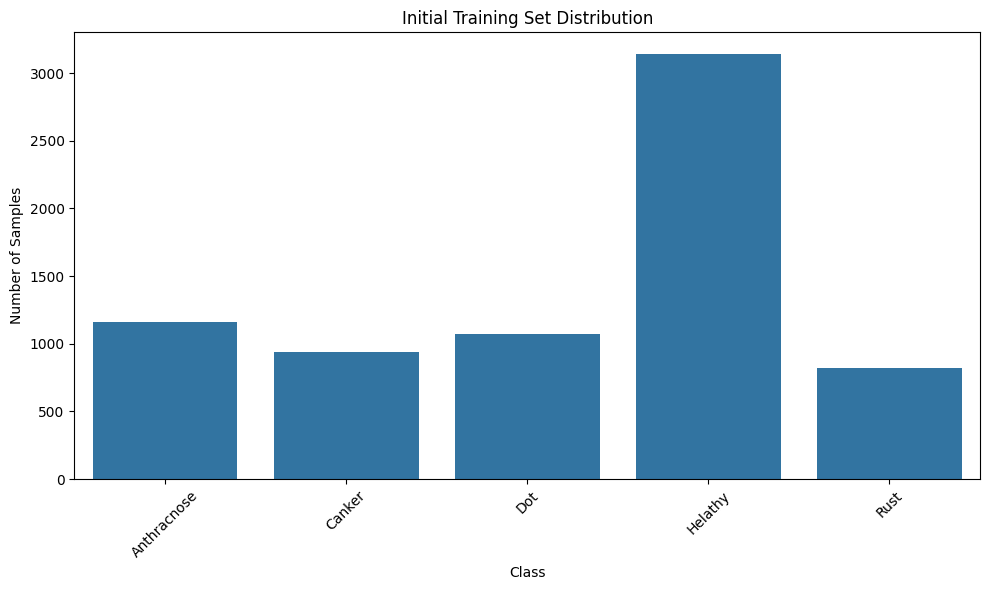

In [10]:
print("\nInitial training set distribution:")
train_dir = os.path.join(output_dir, "train")
initial_counts = visualize_distribution(train_dir, "Initial Training Set Distribution")

## Balance Training Dataset

In [11]:
if BALANCE_DATASET:
    print("\nBalancing training dataset...")

    class_counts = get_class_distribution(train_dir)

    if TARGET_SAMPLES_PER_CLASS is None:
        target_count = max(class_counts.values())
    else:
        target_count = TARGET_SAMPLES_PER_CLASS

    print(f"Balancing dataset to {target_count} samples per class...")
    print(f"Current distribution: {class_counts}")

    for class_name, current_count in class_counts.items():
        if current_count >= target_count:
            print(
                f"Class '{class_name}' already has sufficient samples ({current_count})"
            )
            continue

        class_path = os.path.join(train_dir, class_name)
        images = [
            f
            for f in os.listdir(class_path)
            if f.lower().endswith(("png", "jpg", "jpeg"))
        ]

        needed_samples = target_count - current_count
        print(f"Generating {needed_samples} samples for class '{class_name}'")

        for i in range(needed_samples):
            aug_method = random.choice(["cutmix", "mixup", "mosaic"])

            if aug_method == "cutmix":
                img1_path = os.path.join(class_path, random.choice(images))
                img2_path = os.path.join(class_path, random.choice(images))

                img1 = Image.open(img1_path).convert("RGB")
                img2 = Image.open(img2_path).convert("RGB")

                augmented_img = cutmix_augmentation(img1, img2)

            elif aug_method == "mixup":
                img1_path = os.path.join(class_path, random.choice(images))
                img2_path = os.path.join(class_path, random.choice(images))

                img1 = Image.open(img1_path).convert("RGB")
                img2 = Image.open(img2_path).convert("RGB")

                augmented_img = mixup_augmentation(img1, img2)

            elif aug_method == "mosaic":
                selected_imgs = []
                for _ in range(4):
                    img_path = os.path.join(class_path, random.choice(images))
                    selected_imgs.append(Image.open(img_path).convert("RGB"))

                augmented_img = mosaic_augmentation(selected_imgs)

            aug_filename = f"aug_{aug_method}_{i:04d}.jpg"
            augmented_img.save(os.path.join(class_path, aug_filename))
            images.append(aug_filename) 

    print("Dataset balancing completed!")


Balancing training dataset...
Balancing dataset to 3145 samples per class...
Current distribution: {'Anthracnose': 1161, 'Canker': 940, 'Dot': 1073, 'Helathy': 3145, 'Rust': 818}
Generating 1984 samples for class 'Anthracnose'
Generating 2205 samples for class 'Canker'
Generating 2072 samples for class 'Dot'
Class 'Helathy' already has sufficient samples (3145)
Generating 2327 samples for class 'Rust'
Dataset balancing completed!


## Visualize Final Distribution


Final balanced training set distribution:


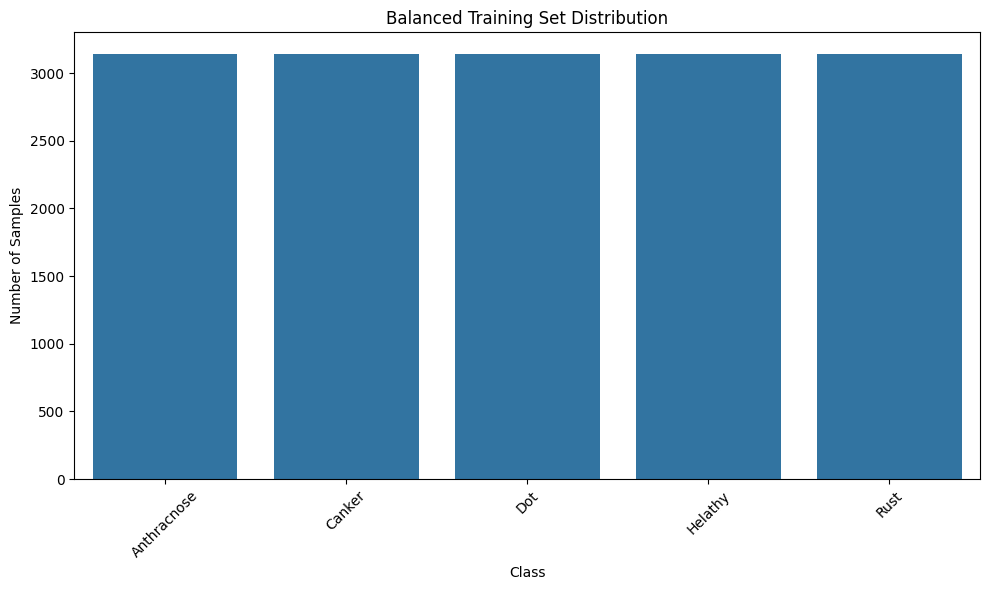


Balancing Summary:
  Anthracnose: 1161 -> 3145 (+1984)
  Canker: 940 -> 3145 (+2205)
  Dot: 1073 -> 3145 (+2072)
  Helathy: 3145 -> 3145 (+0)
  Rust: 818 -> 3145 (+2327)


In [12]:
if BALANCE_DATASET:
    print("\nFinal balanced training set distribution:")
    balanced_counts = visualize_distribution(
        train_dir, "Balanced Training Set Distribution"
    )

    print(f"\nBalancing Summary:")
    for class_name in initial_counts.keys():
        initial = initial_counts[class_name]
        final = balanced_counts[class_name]
        added = final - initial
        print(f"  {class_name}: {initial} -> {final} (+{added})")

## Final Dataset Statistics

In [13]:
print(f"\nFinal Dataset Statistics:")
for split in ["train", "val", "test"]:
    split_dir = os.path.join(output_dir, split)
    split_counts = get_class_distribution(split_dir)
    total = sum(split_counts.values())
    print(f"\n{split.capitalize()} set: {total} samples")
    for class_name, count in split_counts.items():
        print(f"  {class_name}: {count}")

print("\nDataset preparation completed successfully!")


Final Dataset Statistics:

Train set: 15725 samples
  Anthracnose: 3145
  Canker: 3145
  Dot: 3145
  Helathy: 3145
  Rust: 3145

Val set: 1527 samples
  Anthracnose: 248
  Canker: 201
  Dot: 229
  Helathy: 674
  Rust: 175

Test set: 1535 samples
  Anthracnose: 250
  Canker: 203
  Dot: 231
  Helathy: 675
  Rust: 176

Dataset preparation completed successfully!
